In [6]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook, tnrange
import glob

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from PIL import Image, ImageDraw, ImageFile

from skimage.external import tifffile


import tensorflow as tf
import keras

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K

In [ ]:
data = 'data/xview2/xview2_tier3/'

IMAGE_DIR = os.path.join(data, 'snippet_test_images')
OUTPUT_DIR = os.path.join(data, 'snippet_test_images_dim')

image_glob_paths = os.path.join(IMAGE_DIR, '*_disaster.png')

split_dimension = 128
image_dimension = 1024
image_channels = 3
mask_channels = 1
RGB_bits = 2047  # RGB images
mask_bits = 255  # grayscale

# train_percentage = 1
train_percentage = 0.1
snippet_image_paths = glob.glob(image_glob_paths)

train_index = int((len(snippet_image_paths) * train_percentage) // 1)

if train_percentage != 1:
    snippet_image_paths = snippet_image_paths[:train_index]


print(f'Splitting {len(snippet_image_paths)} images'

In [ ]:
total_ids = image_ids
train_index = int((len(total_ids) * train_percentage) // 1)
ids = image_ids[:train_index]

X = np.zeros((len(ids), image_dimension, image_dimension, image_channels))
y = np.zeros((len(ids), image_dimension, image_dimension, image_channels), dtype=dtype_float)

print('Getting and resizing images ... ')

x_min = 1000
x_max = 0
y_min = 1000
y_max = 0

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    image_path = os.path.join(image_dir, f'{image_prefix}{id_}.tif')
    mask_path = os.path.join(output_dir, f'{id_}_mask.tif')
    
    if not (os.path.exists(image_path) and os.path.exists(mask_path)):
        continue
    
    img = tifffile.imread(image_path)
    
    x_img = img
    x_mask = x_img
    x_mask_min = x_mask.min()
    x_mask_max = x_mask.max()
    if x_mask_max > x_max:
        x_max = x_mask_max
    
    if x_mask_min < x_min:
        x_min = x_mask_min
                  
#     x_img = img_to_array(img)
#     x_img = resize(x_img, (image_dimension, image_dimension, image_channels),
#                    mode='constant', preserve_range=True)

    # Load masks
    mask = tifffile.imread(mask_path)
    y_mask = mask
    
    y_mask_min = y_mask.min()
    y_mask_max = y_mask.max()
    if y_mask_max > y_max:
        y_max = y_mask_max
    
    if y_mask_min < y_min:
        y_min = y_mask_min

In [2]:

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

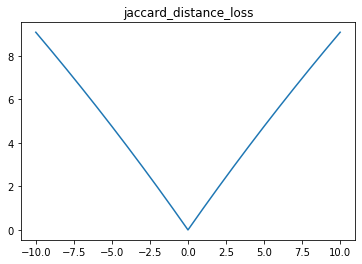

TYPE                 |Almost_right |half right |all_wrong
jaccard_distance_loss [0.09900928 0.89108944 3.7500024 ]
binary_crossentropy [ 0.02634021  0.57564634 12.532434  ]
binary_crossentropy_scaled [0.00210176 0.04593252 1.        ]


In [8]:

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


# Test and plot
y_pred = np.array([np.arange(-10, 10+0.1, 0.1)]).T
y_true = np.zeros(y_pred.shape)
name='jaccard_distance_loss'
try:
    loss = jaccard_distance_loss(
        K.variable(y_true),K.variable(y_pred)
    ).eval(session=K.get_session())
except Exception as e:
    print("error plotting", name ,e)
else:
    plt.title(name)
    plt.plot(y_pred,loss)
    plt.show()
    
# Test
# Test
print("TYPE                 |Almost_right |half right |all_wrong")
y_true = np.array([
    [0,0,1,0]
    [0,0,1,0]
    [0,0,1.,0.]
])
y_pred = np.array([
    [0,0,0.9,0],
    [0,0,0.1,0]
    [1,1,0.1,1.]
])

r = jaccard_distance_loss(
    K.variable(y_true),
    K.variable(y_pred),
).eval(session=K.get_session())
print('jaccard_distance_loss',r)
assert r[0]<r[1]
assert r[1]<r[2]

r = keras.losses.binary_crossentropy(
    K.variable(y_true),
    K.variable(y_pred),
).eval(session=K.get_session())
print('binary_crossentropy',r)
print('binary_crossentropy_scaled',r/r.max())
assert r[0]<r[1]
assert r[1]<r[2]


In [16]:
y_true = np.zeros((2, 3, 3, 2))
y_pred = np.zeros((2, 3, 3, 2))

y_true[0, ...] = np.random.randint(0, 2, 3 * 3 * 2).reshape((3, 3, 2))
y_pred[0, ...] = np.random.randint(0, 2, 3 * 3 * 2).reshape((3, 3, 2))



In [17]:
y_pred

array([[[[1., 0.],
         [0., 0.],
         [1., 1.]],

        [[0., 0.],
         [0., 0.],
         [0., 1.]],

        [[1., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]]])

In [18]:
y_true

array([[[[1., 0.],
         [1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 1.],
         [1., 0.]],

        [[0., 1.],
         [1., 0.],
         [0., 1.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]]])

In [19]:
np.sum()

TypeError: 'list' object cannot be interpreted as an integer